In [1]:
from json import load
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from elyawy.io import load_sims_df
from elyawy.constants import SUMSTATS_LIST

In [2]:

res_path = (Path.home() / "Data/Bacillus_1ZARG/").resolve() # os.path.join(all_outputs_path, dir_name)
print(res_path)
full_data, regressors, reg_stats = load_sims_df(data_path=res_path, correction=True)

/home/elyalab/Data/Bacillus_1ZARG


In [3]:
full_zipf = shuffle(full_data[full_data["length_distribution"] == "zipf"])
full_geometric = shuffle(full_data[full_data["length_distribution"] == "geometric"])
full_poisson = shuffle(full_data[full_data["length_distribution"] == "poisson"])
num_test = 400
test_zipf = full_zipf[:num_test]
test_geometric = full_geometric[:num_test]
test_poisson = full_poisson[:num_test]

test_data = shuffle(pd.concat([test_zipf, test_geometric, test_poisson]))
remaining_data = shuffle(pd.concat([full_zipf[num_test:],full_geometric[num_test:], full_poisson[num_test:]]))

In [5]:
test_data_sum_stats = test_data[SUMSTATS_LIST].astype("float")
remaining_sum_stats = remaining_data[SUMSTATS_LIST].astype("float")
sum_stat_cov = remaining_sum_stats.cov().values
inv_covmat = np.linalg.inv(sum_stat_cov)

In [6]:
predicted_dist = remaining_data["length_distribution"].reset_index(drop=True)
true_dists = test_data["length_distribution"].reset_index(drop=True)

In [7]:
abc_counts = []
epsilon = 100
count = 0
for u in test_data_sum_stats.values:
    def mahalanobis(simulated_stats):
        u_minus_v = simulated_stats-u
        left = np.dot(u_minus_v, inv_covmat)
        mahal = np.sqrt(np.sum(u_minus_v*left, axis=1))
        return mahal
    distances_from_u = mahalanobis(remaining_sum_stats).reset_index(drop=True)
    distances_from_u.name = "distances"
    distances_from_u = pd.concat([distances_from_u, predicted_dist], axis=1)
    distances_from_u.columns = ["distances", "predicted_distribution"]

    dist_distribution = distances_from_u.nsmallest(epsilon, columns="distances")
    dist_distribution = dist_distribution["predicted_distribution"].value_counts()
    dist_distribution.name = f'{count}'
    count+=1
    abc_counts.append(dist_distribution)
all_counts = pd.concat(abc_counts,  axis=1)


In [8]:
abc_winners = pd.DataFrame(all_counts.fillna(0).idxmax())
abc_winners.columns = ["predicted"]

In [9]:
td_list = true_dists[:count]
td_list.name = "true_dists"
td_list = pd.DataFrame(td_list).T
td_list.columns = all_counts.columns
final_results = pd.concat([all_counts.fillna(0), abc_winners.T, td_list]).T

In [10]:
final_results

,geometric,zipf,poisson,predicted,true_dists
0,98.0,2.0,0.0,geometric,geometric
1,0.0,100.0,0.0,zipf,zipf
2,0.0,100.0,0.0,zipf,zipf
3,0.0,100.0,0.0,zipf,zipf
4,0.0,0.0,100.0,poisson,poisson
...,...,...,...,...,...
1195,0.0,0.0,100.0,poisson,poisson
1196,0.0,0.0,100.0,poisson,poisson
1197,100.0,0.0,0.0,geometric,geometric
1198,95.0,0.0,5.0,geometric,geometric


In [11]:
final_results.to_csv(res_path / f"selection_results_{epsilon}.csv")

In [12]:
confusion_matrix = pd.crosstab(final_results["true_dists"], final_results["predicted"])

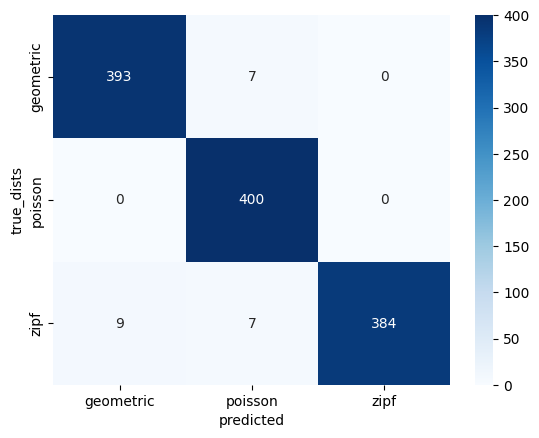

In [13]:
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.savefig(res_path / f"selection_results_{epsilon}.png", dpi=200)